# scGen: a landmark generative model for unseen perturbations
---

## 1. Introduction

Single-cell RNA-sequencing (scRNA-seq) has made it possible to measure how thousands of individual cells change their transcriptional programs in response to genetic, chemical, or environmental **perturbations**.  
However, performing every possible perturbation in the wet lab is infeasible; the search space explodes combinatorially, and many experiments are costly or technically difficult.  

**Perturbation‐response models**—such as **scGen**—aim to fill this gap by *predicting* how an unobserved condition would rewrite the transcriptome, given (i) gene-expression data from control cells and (ii) knowledge of a related perturbation. scGen combines a variational autoencoder with latent vector arithmetic to simulate “treated” cells that have never been sequenced. Yet a model is only as good as the evidence supporting it.  

The goal of this notebook is therefore two-fold:
1. **Methodological** – demonstrate a **reproducible benchmarking pipeline** for scGen using the Perturb-Bench toolbox.  
2. **Practical** – show you how to inspect and interpret scGen’s predictions with both **statistical metrics** and **biological read-outs**.

---

### 1.1  What you will learn  

| Step | Key concept | Why it matters |
|------|-------------|----------------|
| **Data loading** | AnnData, metadata harmonisation | Consistent structures make downstream analysis trivial. |
| **Pre-processing** | Normalisation, highly-variable gene (HVG) selection | Removes technical noise and speeds up training. |
| **Model training** | scGen VAE, latent arithmetic | Generates *in silico* perturbations. |
| **Evaluation** | R², Pearson r, logFC overlap, distance metrics | Quantifies how close predictions are to real data. |
| **Biological validation** | Gene regulatory networks, pathway enrichment, marker recovery | Tests whether predictions respect known biology. |

---

### 1.2  Why start with the [*Stephenson 2021*](https://figshare.com/articles/dataset/Stephenson_Covid-19_PBMC_2021_BCR/22132946?file=39347336) dataset?  

*   It provides a clean **control vs LPS** immune-stimulation experiment with well-annotated cell types.  
*   The subsample (~3 k cells) trains quickly on CPU/GPU, making it ideal for a workshop setting.  
*   Its moderate complexity lets us illustrate the full pipeline **without** overwhelming computational cost.

> **Beyond this tutorial**  
> The same workflow generalises to multi-study, cross-species, temporal, or disease-state perturbations—simply swap in a different `pt.data.*` loader or your own `.h5ad` file.

---

### 1.3  Roadmap  

1. **Load & explore data** *(Stephenson 2021, control vs LPS)*  
2. **Pre-process** counts → logCPM, select 2 000 HVGs  
3. **Train scGen** (30 epochs) with reproducible seeds  
4. **Score predictions** using both statistical and biological metrics  
5. **Visualise** true vs predicted log fold-changes  
6. **Save** the trained model and processed dataset for future work

Let’s jump in!

---

## 2. Environment Setup & Imports

In [1]:
# --- Standard-library utilities ------------------------------------------------
import os                 # file-system operations (e.g. os.environ or os.path)
import sys                # Python runtime details; we use it for version checks
import time               # simple timing / benchmarking of cells
from pathlib import Path  # convenient, cross-platform path handling
from collections import OrderedDict  # deterministic dicts for reproducible logs
import random             # Python RNG (seeded below for reproducibility)

# --- Numerical & data-handling stack ------------------------------------------
import numpy as np        # dense numerical arrays
import pandas as pd       # tabular data frames
from scipy import sparse  # sparse matrix utilities
from scipy import stats   # statistical functions (e.g. t-tests, correlations)
from scipy.spatial.distance import cosine as cosine_dist, cdist  # distance metrics

# --- Single-cell analysis ecosystem -------------------------------------------
import scanpy as sc       # core single-cell workflow (AnnData, QC, plotting)
import pertpy as pt       # Perturb-Bench helpers: dataset loaders & metrics
from scvi import REGISTRY_KEYS  # keys used by scvi-tools / scGen for AnnData metadata

# --- Deep-learning backend -----------------------------------------------------
import torch              # PyTorch (Tensor operations and GPU acceleration)

# --- Machine-learning utilities ----------------------------------------------
from sklearn.decomposition import PCA                # dimensionality reduction
from sklearn.linear_model import LogisticRegression  # classifier used in metrics
from sklearn.neighbors import KernelDensity          # density estimation
from sklearn.metrics import (
    pairwise_distances,   # generic distance matrix
    silhouette_score,     # clustering quality
    roc_auc_score         # AUROC for binary classification tasks
)

# --- Plotting & visualisation --------------------------------------------------
import matplotlib.pyplot as plt  # base plotting library
import seaborn as sns            # higher-level statistical plots

# --- Global reproducibility ----------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True   # exact determinism (may reduce speed)
torch.backends.cudnn.benchmark = False

print(f"Random seed set to {SEED}")

Random seed set to 42


---

## 3. Data Exploration & Preparation

### 3.1 Loading and Exploring the *Stephenson 2021* dataset

We begin by loading a subsampled version of the *Stephenson 2021* dataset that will be used throughout this notebook.

In [2]:
# adata = pt.data.stephenson_2021_subsampled() # loading the data by downloading the file
adata = sc.read('data/stephenson_2021_subsampled.h5ad') # loading the data directly from the file

adata # viewing the data

AnnData object with n_obs × n_vars = 62509 × 16299
    obs: 'Collection_Day', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'cell_type', 'dataset_group'
    var: 'gene_id', 'gene_name'
    uns: 'log1p', 'umap'
    obsm: 'X_scVI', 'X_umap'

[`AnnData`](https://anndata.readthedocs.io/) is the de-facto container for single-cell data in Python (used by **Scanpy**, **scvi-tools**, **Perturb-Bench**, and many other packages). Think of it as a tidy “Excel workbook” with one big table of gene expression and several *linked* annotation sheets:

| Attribute | Purpose | In our dataset |
|-----------|---------|----------------|
| **`.X`** *(n_obs × n_vars)* | The main numerical matrix – usually raw counts, log-counts, or latent embeddings. Rows = **cells** (*observations*), columns = **genes** (*variables*). | 62,509 cells (drawn from peripheral blood mononuclear cells (PBMCs)) × 16,299 genes (log-normalised counts, after basic filtering by the original authors). |
| **`.obs`** | Per-cell metadata (pandas `DataFrame`). | 21 columns – e.g. `cell_type`, `time_after_LPS`, `patient_id`, `Status` (control, Covid, LPS). |
| **`.var`** | Per-gene metadata. | `gene_id`, `gene_name`. |
| **`.layers`** | Alternative expressions of `.X` (raw counts, denoised counts, predictions …). | Empty for now – we’ll add `counts` and `corrected` later. |
| **`.uns`** | Unstructured info: colour maps, model parameters, etc. | Contains Scanpy’s `log1p` settings and pre-computed UMAP. |
| **`.obsm` / `.varm`** | Multi-dimensional annotations (matrices): embeddings, feature scores. | `X_umap` (2-D UMAP) and `X_scVI` (latent space). |
| **`.obsp` / `.varp`** | Pairwise matrices (graphs, distances). | Not present yet. |

In [3]:
adata.obs.head(10)  # viewing the first 10 rows of the observation metadata (cell-level)

,Collection_Day,Swab_result,Status,Smoker,Status_on_day_collection,Status_on_day_collection_summary,Days_from_onset,Site,time_after_LPS,Worst_Clinical_Status,...,patient_id,author_cell_type,organism,sex,tissue,ethnicity,disease,assay,cell_type,dataset_group
10_1038_s41591_021_01329_2-S11_GAGTCCGGTTCAGGCC-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,CD4.Tfh,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,T follicular helper cell,P
10_1038_s41591_021_01329_2-S12_ACTGTCCTCTCGTATT-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,CD4.CM,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,"central memory CD4-positive, alpha-beta T cell",P
10_1038_s41591_021_01329_2-S12_CTCTAATAGTTTCCTT-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,NK_16hi,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,"CD16-positive, CD56-dim natural killer cell, h...",P
10_1038_s41591_021_01329_2-S12_GCATACAGTAATCGTC-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,CD8.Naive,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,"naive thymus-derived CD8-positive, alpha-beta ...",P
10_1038_s41591_021_01329_2-S12_GACTGCGTCCTTTCGG-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,NK_16hi,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,"CD16-positive, CD56-dim natural killer cell, h...",P
10_1038_s41591_021_01329_2-S11_CAAGGCCAGGGATGGG-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,CD14_mono,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,CD14-positive monocyte,P
10_1038_s41591_021_01329_2-S11_CGGTTAATCGGATGGA-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,CD8.EM,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,"effector memory CD8-positive, alpha-beta T cell",P
10_1038_s41591_021_01329_2-S11_GATCTAGTCACTATTC-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,B_naive,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,naive B cell,P
10_1038_s41591_021_01329_2-S11_CATGACAAGGTGCACA-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,CD4.CM,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,"central memory CD4-positive, alpha-beta T cell",P
10_1038_s41591_021_01329_2-S12_CTCGGAGTCCGTTGCT-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,gdT,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,gamma-delta T cell,P


In [4]:
adata.var.head(10)  # viewing the first 10 rows of the variable metadata (gene-level)

,gene_id,gene_name
FAM87B,ENSG00000177757,FAM87B
LINC00115,ENSG00000225880,LINC00115
FAM41C,ENSG00000230368,FAM41C
SAMD11,ENSG00000187634,SAMD11
NOC2L,ENSG00000188976,NOC2L
KLHL17,ENSG00000187961,KLHL17
PLEKHN1,ENSG00000187583,PLEKHN1
PERM1,ENSG00000187642,PERM1
HES4,ENSG00000188290,HES4
ISG15,ENSG00000187608,ISG15


---

### 3.2 Preparing the *Stephenson 2021* dataset for scGen

Key `.obs` columns you will use in this tutorial:
| Column | Description |
|--------|-------------|
| `cell_type` | High-level cell type annotation (e.g. CD14⁺ monocyte, CD4⁺ T cell) |
| `Status` | Experimental condition: control (untreated) or LPS (lipopolysaccharide-stimulated) |
| `patient_id` | Patient identifier (useful for batch correction / cross-validation) | 
| `time_after_LPS` | Hours since LPS stimulation (continuous covariate) |

In [5]:
display(adata.obs['Status'].value_counts())  # counting the number of cells in each condition

Status
Covid      48083
Healthy    11790
LPS         2636
Name: count, dtype: int64

For the purpose of this tutorial, we will further downsample the dataset to 13,000 cells, which is a manageable size for training scGen on a standard laptop.

In [6]:
# ------------------------------------------------------------------
# Sub-sample to 13 000 cells while preserving the Status proportions
# ------------------------------------------------------------------
target_total = 13_000                     # final size
status_col   = "Status"                   # column with the class labels
rng          = SEED                       # for reproducibility

# 1) Desired sample size per class (rounded)
status_counts  = adata.obs[status_col].value_counts()
target_counts  = (
    (status_counts / status_counts.sum()) * target_total
).round().astype(int)

# 2) Make sure rounding still sums to target_total
diff = target_total - target_counts.sum()
if diff != 0:                        # add/subtract the remainder to the largest class
    largest = target_counts.idxmax()
    target_counts[largest] += diff

print("Sampling plan:\n", target_counts.to_string(), "\n")

# 3) Collect indices stratified by Status
idx_list = []
for status, n in target_counts.items():
    idx = (
        adata.obs.query(f"{status_col} == @status")
        .sample(n, random_state=rng)
        .index
    )
    idx_list.append(idx)

subset_idx = np.concatenate(idx_list)

# 4) Create the down-sampled AnnData object
adata_sub = adata[subset_idx].copy()

# 5) Sanity-check the new distribution
display(adata_sub.obs[status_col].value_counts())

print(f"\nFinal shape: {adata_sub.n_obs:,} cells × {adata_sub.n_vars:,} genes")

Sampling plan:
 Status
Covid      10000
Healthy     2452
LPS          548 



Status
Covid      10000
Healthy     2452
LPS          548
Name: count, dtype: int64


Final shape: 13,000 cells × 16,299 genes


For this tutorial, we will focus on the `Status` column to compare **control vs LPS-stimulated cells** and figure out how well scGen can predict the transcriptional changes induced by LPS treatment.

In [7]:
norm_data = adata_sub[adata_sub.obs["Status"] != "Covid"] # filtering out COVID cells

norm_data # viewing the normal data (non-COVID cells)

View of AnnData object with n_obs × n_vars = 3000 × 16299
    obs: 'Collection_Day', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'cell_type', 'dataset_group'
    var: 'gene_id', 'gene_name'
    uns: 'log1p', 'umap'
    obsm: 'X_scVI', 'X_umap'

In [8]:
display(norm_data.obs['Status'].value_counts())  # counting the number of cells per status in the normal data

Status
Healthy    2452
LPS         548
Name: count, dtype: int64

We then create a subset of our subsampled dataset that contains only the top 5 most abundant cell types, which will help us focus on the most relevant biological signals and reduce computational complexity.

In [9]:
# 1) Subset to top-5 cell types
counts = norm_data.obs["cell_type"].value_counts()
top5   = counts.head(5).index.tolist()

# 2) Subset the AnnData
norm_data_qc = norm_data[norm_data.obs["cell_type"].isin(top5)].copy()

# 3) Verify
print("Kept cell counts:")
display(norm_data_qc.obs["cell_type"].value_counts())

Kept cell counts:


cell_type
CD16-positive, CD56-dim natural killer cell, human      445
naive thymus-derived CD4-positive, alpha-beta T cell    370
naive B cell                                            274
CD14-positive monocyte                                  252
naive thymus-derived CD8-positive, alpha-beta T cell    247
Name: count, dtype: int64

In [10]:
display(norm_data_qc.obs['Status'].value_counts()) # counting the number of cells per status in the normal data after QC

Status
Healthy    1229
LPS         359
Name: count, dtype: int64

We then proceed to filter out low-quality cells based on the number of genes expressed and the total counts, ensuring that we retain only high-quality cells for training.

Finally, we will normalise the data using logCPM (counts per million) and select the top 2,000 highly variable genes (HVGs) to speed up training and focus on the most informative features.

In [11]:
norm_data_qc_hvg = norm_data_qc.copy() # creating a copy of the AnnData object for highly variable genes (HVG) analysis


sc.pp.highly_variable_genes(
    norm_data_qc_hvg,
    n_top_genes=2000,
    flavor="seurat",
    subset=True
)

norm_data_qc_hvg # viewing the AnnData object after HVG selection

AnnData object with n_obs × n_vars = 1588 × 2000
    obs: 'Collection_Day', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'cell_type', 'dataset_group'
    var: 'gene_id', 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'umap', 'hvg'
    obsm: 'X_scVI', 'X_umap'

We can also plot the UMAP of the filtered dataset to visualise the cell types and their distribution in the latent space.

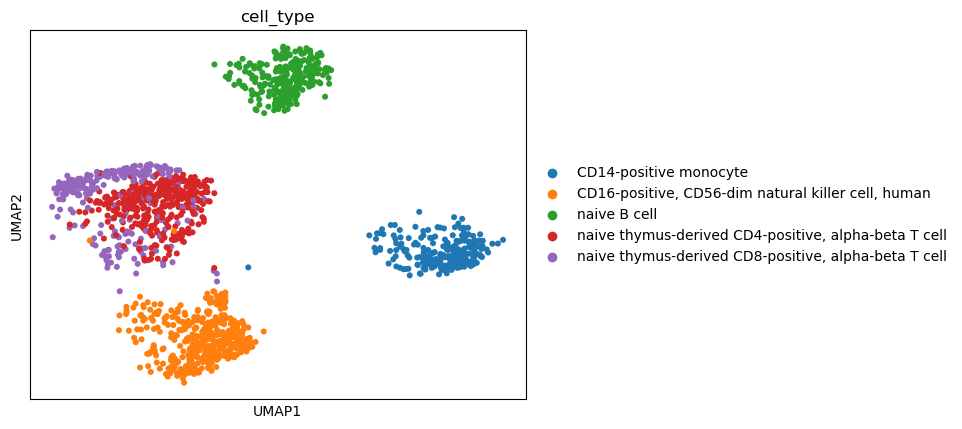

In [12]:
sc.pl.umap(norm_data_qc_hvg, color = "cell_type")

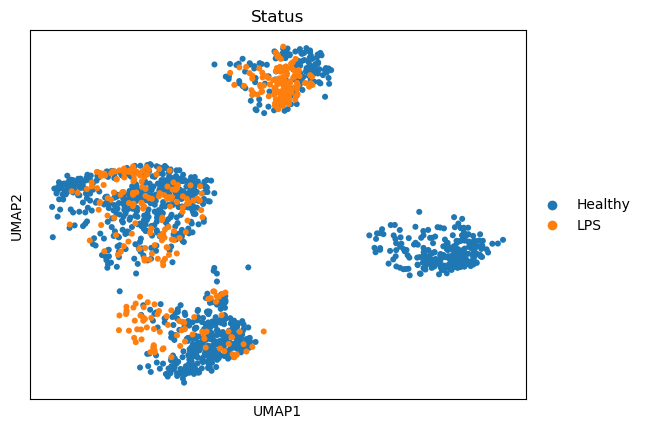

In [13]:
sc.pl.umap(norm_data_qc_hvg, color = "Status")

Finally, before proceeding with the training, we will rename the `.obs` columns to match the expected format for scGen:
* The 'Status' column will be renamed to 'label', where:
  * Control cells will be designated as "ctrl"
  * LPS-stimulated cells will be designated as "stim"

In [14]:
# Perturbation column
norm_data_qc_hvg.obs.rename(columns={"Status": "label"}, inplace=True)

norm_data_qc_hvg

AnnData object with n_obs × n_vars = 1588 × 2000
    obs: 'Collection_Day', 'Swab_result', 'label', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'cell_type', 'dataset_group'
    var: 'gene_id', 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'umap', 'hvg', 'cell_type_colors', 'Status_colors'
    obsm: 'X_scVI', 'X_umap'

In [15]:
# Change the name of control and perturbed cells
norm_data_qc_hvg.obs["label"] = norm_data_qc_hvg.obs["label"].cat.rename_categories({"Healthy": "ctrl", "LPS": "stim"})

display(norm_data_qc_hvg.obs["label"].value_counts())  # counting the number of cells per label

label
ctrl    1229
stim     359
Name: count, dtype: int64

---

## 4. Training & Evaluation with scGen

In this section we:
1. configure global hyper-parameters and choose CPU/GPU,
2. define the helper functions used across metrics,
3. wrap training + prediction for a single cell-type in a reusable function,
4. loop over cell-types and gene-sets (all genes vs top K DEGs),
5. collect results and draw a summary dashboard.


In [16]:
# ── Device & run-time options ────────────────────────────────────────────
cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f"Running on {'GPU' if cuda_available else 'CPU'} – "
      f"{torch.cuda.get_device_name(0) if cuda_available else 'no CUDA device'}")

# ── Hyper-parameter options ──────────────────────────
n_epochs        = 10 #100
batch_size      = 32 
K_DEGS          = 100          # top-K genes for DE overlap
pca_components  = 30
ctrl_key, stim_key = "ctrl", "stim"
condition_col, celltype_col = "label", "cell_type"

GENE_SETS = [("all_genes", None),          # None  = use all genes
             (f"top {K_DEGS} DEGs", K_DEGS)]


Running on CPU – no CUDA device


In [17]:
# ======================================================================
# Metrics & utilities
# ======================================================================

def mean_var_kde_distance(X1, X2, bandwidth=1.0, grid_size=50):
    """L1 distance between mean–variance KDEs; returns NaN if no valid genes."""
    m1, v1 = X1.mean(0), X1.var(0)
    m2, v2 = X2.mean(0), X2.var(0)
    pts1, pts2 = np.column_stack([m1, v1]), np.column_stack([m2, v2])

    # ── NEW guard against NaNs ─────────────────────────────
    nan_mask = ~(np.isnan(pts1).any(1) | np.isnan(pts2).any(1))
    pts1, pts2 = pts1[nan_mask], pts2[nan_mask]
    if pts1.shape[0] == 0 or pts2.shape[0] == 0:
        return np.nan
    # -------------------------------------------------------

    mins = np.minimum(pts1.min(0), pts2.min(0))
    maxs = np.maximum(pts1.max(0), pts2.max(0))
    xs = np.linspace(mins[0], maxs[0], grid_size)
    ys = np.linspace(mins[1], maxs[1], grid_size)
    grid = np.column_stack(np.meshgrid(xs, ys)).reshape(-1, 2)

    kde1 = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(pts1)
    kde2 = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(pts2)

    d1 = np.exp(kde1.score_samples(grid))
    d2 = np.exp(kde2.score_samples(grid))
    dx, dy = xs[1]-xs[0], ys[1]-ys[0]
    return float(np.abs(d1 - d2).sum() * dx * dy)



def bootstrap_metrics(X, real_mask, pred_mask, pca_coords,
                      n_boot=200, frac=0.8, seed=0, sigma=1.0):
    """Bootstrap a panel of bulk-level error metrics."""
    if real_mask.sum() == 0 or pred_mask.sum() == 0:
        return {f"{k}_{s}": np.nan for k in
                ["R2","MSE","RMSE","MAE","L2","Pearson","Cosine","Edist","MMD","Euc"]
                for s in ("mean","std")}

    rng = np.random.default_rng(seed)
    r_idx, p_idx = np.where(real_mask)[0], np.where(pred_mask)[0]
    s_r, s_p = max(1, int(frac*len(r_idx))), max(1, int(frac*len(p_idx)))

    keys  = ["R2","MSE","RMSE","MAE","L2","Pearson","Cosine","Edist","MMD","Euc"]
    store = {k: [] for k in keys}

    for _ in range(n_boot):
        r = rng.choice(r_idx, s_r, replace=True)
        p = rng.choice(p_idx, s_p, replace=True)
        Y, Xp = X[r].mean(0), X[p].mean(0)
        d     = Xp - Y

        store["MSE"].append(np.mean(d**2))
        store["RMSE"].append(np.sqrt(np.mean(d**2)))
        store["MAE"].append(np.mean(np.abs(d)))
        store["L2"].append(np.linalg.norm(d))
        store["Pearson"].append(stats.pearsonr(Xp, Y)[0])
        store["Cosine"].append(1 - cosine_dist(Xp, Y))

        ss_res = ((Y - Xp)**2).sum(); ss_tot = ((Y - Y.mean())**2).sum()
        store["R2"].append(1 - ss_res/ss_tot if ss_tot>0 else np.nan)

        Pr, Pp = pca_coords[r], pca_coords[p]
        store["Euc"].append(np.linalg.norm(Pr.mean(0) - Pp.mean(0)))

        d_rr = pairwise_distances(Pr, Pr); d_pp = pairwise_distances(Pp, Pp)
        d_rp = pairwise_distances(Pr, Pp)
        store["Edist"].append(2*d_rp.mean() - d_rr.mean() - d_pp.mean())

        Krr = np.exp(-cdist(Pr, Pr,'sqeuclidean')/(2*sigma**2))
        Kpp = np.exp(-cdist(Pp, Pp,'sqeuclidean')/(2*sigma**2))
        Krp = np.exp(-cdist(Pr, Pp,'sqeuclidean')/(2*sigma**2))
        store["MMD"].append(Krr.mean() + Kpp.mean() - 2*Krp.mean())

    out = {}
    for k,v in store.items():
        out[f"{k}_mean"] = float(np.nanmean(v))
        out[f"{k}_std"]  = float(np.nanstd(v))
    return out

def compute_dist_scaled(X, ctrl_m, stim_m, pred_m, eps=1e-8):
    """Scaled Euclidean distance (pred-vs-stim)/(ctrl-vs-stim)."""
    m0, m1, m2 = X[ctrl_m].mean(0), X[stim_m].mean(0), X[pred_m].mean(0)
    ok = ~(np.isnan(m0)|np.isnan(m1)|np.isnan(m2))
    return np.linalg.norm(m2[ok]-m1[ok]) / (np.linalg.norm(m0[ok]-m1[ok]) + eps)

In [18]:
def run_scgen_for_celltype(
    adata, celltype,
    n_genes=None, device=torch.device("cpu"),
    epochs=10, batch_size=32,
    pca_dim=30
):
    # 1) build training set
    train_adata = adata[~(
        (adata.obs["cell_type"] == celltype) &
        (adata.obs["label"]     == "stim")
    )].copy()

    if n_genes:
        sc.pp.highly_variable_genes(train_adata, n_top_genes=n_genes,
                                    flavor="seurat_v3", subset=True)

    # 2) set up & train scGEN
    pt.tl.Scgen.setup_anndata(train_adata,
                              batch_key="label",
                              labels_key="cell_type")

    model = pt.tl.Scgen(train_adata)
    model.train(
        max_epochs     = epochs,
        batch_size     = batch_size,
        early_stopping = True,
        accelerator    = ("gpu" if device.type == "cuda" else "cpu"),
        devices        = 1
    )

    # 3) predict held-out cell-type
    pred, _ = model.predict(
        ctrl_key="ctrl", stim_key="stim",
        celltype_to_predict=celltype
    )
    pred.obs["label"] = "pred"

    # 4) evaluation AnnData
    ctrl = adata[(adata.obs["cell_type"]==celltype)&(adata.obs["label"]=="ctrl")]
    stim = adata[(adata.obs["cell_type"]==celltype)&(adata.obs["label"]=="stim")]
    eval_ad = ctrl.concatenate(stim, pred)
    eval_ad.obs["label"] = eval_ad.obs["label"].astype("category")

    sc.tl.pca(eval_ad, n_comps=pca_dim, svd_solver="arpack")
    return eval_ad

### 4.1. Loop over cell-types and gene-sets  

We now iterate:
* each **cell-type** present in the dataset  
* two **gene sets** – all genes vs top 100 DEGs  
For every combination we call `run_scgen_for_celltype`, compute metrics, and store a row in `results_df`.


In [ ]:
results = []
common_celltypes = norm_data_qc_hvg.obs[celltype_col].unique()

for gene_label, topN in GENE_SETS:
    for ct in common_celltypes:
        eval_ad = run_scgen_for_celltype(
            norm_data_qc_hvg, ct,
            n_genes=topN, device=device,
            epochs=n_epochs, batch_size=batch_size
        )

        # masks & matrices
        X      = eval_ad.X.A if sparse.issparse(eval_ad.X) else eval_ad.X
        X_pca  = eval_ad.obsm["X_pca"]
        ctrl_m = eval_ad.obs[condition_col]==ctrl_key
        stim_m = eval_ad.obs[condition_col]==stim_key
        pred_m = eval_ad.obs[condition_col]=="pred"

        boot = bootstrap_metrics(X, stim_m, pred_m, X_pca)
        row  = {
            "cell_type": ct,
            "gene_set":  gene_label,
            "dist_scaled": compute_dist_scaled(X, ctrl_m, stim_m, pred_m),
            "mean_var_dist": mean_var_kde_distance(X[stim_m], X[pred_m]),
            **boot
        }

        # DE-specific metrics only for top-K set
        if gene_label.startswith("top"):
            sc.tl.rank_genes_groups(eval_ad, groupby=condition_col,
                                    reference=ctrl_key, groups=[stim_key,"pred"],
                                    method="wilcoxon", n_genes=eval_ad.n_vars)
            true_top = eval_ad.uns["rank_genes_groups"]["names"][stim_key][:K_DEGS]
            pred_top = eval_ad.uns["rank_genes_groups"]["names"]["pred"][:K_DEGS]
            shared   = set(true_top) & set(pred_top)
            row["jaccard_topK"] = len(shared)/(2*K_DEGS-len(shared))
        results.append(row)

results_df = pd.DataFrame(results)
display(results_df.head())

### 4.2. Metric summary plots  
The next cell draws a grid of bar-plots (mean ± SD) for every metric across cell-types.

In [ ]:
METRICS_TO_PLOT = [
    ("R2_mean","R2_std"), ("MSE_mean","MSE_std"), ("Pearson_mean","Pearson_std"),
    ("dist_scaled",None), ("mean_var_dist",None), ("jaccard_topK",None)
]

cell_types = results_df["cell_type"].unique()
gene_sets  = results_df["gene_set"].unique()
n = len(METRICS_TO_PLOT)
ncols = 3
fig, axes = plt.subplots(int(np.ceil(n/ncols)), ncols, figsize=(5*ncols,4*n), squeeze=False)
axes = axes.ravel()

for ax, (mean_col, std_col) in zip(axes, METRICS_TO_PLOT):
    for i, gs in enumerate(gene_sets):
        subset = results_df[results_df["gene_set"]==gs].set_index("cell_type")
        means  = subset[mean_col].reindex(cell_types)
        errs   = subset[std_col].reindex(cell_types) if std_col else None
        x = np.arange(len(cell_types)) + i*0.35
        ax.bar(x, means, 0.35, yerr=errs if errs is not None else None,
               capsize=3, label=gs)
    ax.set_xticks(np.arange(len(cell_types)) + 0.35*(len(gene_sets)-1)/2)
    ax.set_xticklabels(cell_types, rotation=45, ha="right")
    ax.set_title(mean_col.replace("_mean",""))
    
fig.legend(bbox_to_anchor=(1.02,0.5), loc="center left", title="Gene set")
fig.tight_layout(rect=[0,0,0.85,1])
plt.show()